# Artificial Neural Networks and Deep Learning

---

## Homework 1: Minimal Working Example

To make your first submission, follow these steps:
1. Create a folder named `[2024-2025] AN2DL/Homework 1` in your Google Drive.
2. Upload the `training_set.npz` file to this folder.
3. Upload the Jupyter notebook `Homework 1 - Minimal Working Example.ipynb`.
4. Load and process the data.
5. Implement and train your model.
6. Submit the generated `.zip` file to Codabench.


## 🌐 Connect Colab to Google Drive

In [1]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/AN2DL

Mounted at /gdrive
/gdrive/My Drive/AN2DL


## ⚙️ Import Libraries

In [2]:
pip install keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.7 MB/s eta 0:00:00


In [3]:
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from tensorflow.keras import mixed_precision

import keras_cv as kcv
import pandas as pd
import random
from sklearn.model_selection import train_test_split

seed = 42

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline

np.random.seed(seed)
tf.random.set_seed(seed);

2.17.1


## ⏳ Load the Data

In [4]:
data = np.load('training_set.npz')
X = data['images'] # Array of 13759 images (96x96x3 each)
y = data['labels'] # Array of 13759 labels (numbers from 0 to 7)

X = X[:11959]
y = y[:11959]

TEST_SIZE = round(X.shape[0] / 20) # 10%
VAL_SIZE = round(X.shape[0] / 10) # 10%

# Split the dataset into a combined training and validation set, and a separate test set
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=seed,
    stratify=y
)

# Further split the combined training and validation set into a training set and a validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    test_size=VAL_SIZE,
    random_state=seed,
    stratify=y_train_val
)

class_names = ['Basophil', 'Eosinophil', 'Erythroblast', 'Immature granulocytes', 'Lymphocyte', 'Monocyte', 'Neutrophil', 'Platelet']

from sklearn.utils.class_weight import compute_class_weight
y_cw = np.squeeze(y_train)

classes = np.unique(y_cw)
class_weights = compute_class_weight('balanced', classes=classes, y=y_cw)
# Convert to dictionary
class_weight_dict = dict(zip(classes, class_weights))
print("Class Weights: "+str(class_weight_dict))

# Convert class labels to categorical format for training, validation, and test sets
y_train = tfk.utils.to_categorical(y_train, num_classes=len(class_names))
y_val = tfk.utils.to_categorical(y_val, num_classes=len(class_names))
y_test = tfk.utils.to_categorical(y_test, num_classes=len(class_names))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Class Weights: {0: 1.755006906077348, 1: 0.6853425026968716, 2: 1.3781182212581344, 3: 0.7378774680603949, 4: 1.7598684210526316, 5: 1.5054798578199051, 6: 0.641729797979798, 7: 0.9095382963493199}
X_train shape: (10165, 96, 96, 3), y_train shape: (10165, 8)
X_val shape: (1196, 96, 96, 3), y_val shape: (1196, 8)
X_test shape: (598, 96, 96, 3), y_test shape: (598, 8)


In [5]:
BATCH_SIZE = 64
INPUT_SHAPE = (96, 96, 3)
NUM_CLASSES = 8

augmenter = kcv.layers.Augmenter(
    [
        kcv.layers.RandomFlip(),
        kcv.layers.RandAugment(value_range=(0, 255), magnitude=0.2, augmentations_per_image=4),
        kcv.layers.CutMix(),
    ],
)

# Not using this yet
def normalize_data(image, label):
    image = tf.image.resize(image, (224, 224))  # Resize to (224, 224, 3)
    # Normalize the image to [0, 1]
    image = image / 255.0
    return image, label

def preprocess_data(images, labels, augment=False):
    inputs = {"images": images, "labels": labels}
    outputs = inputs
    if augment:
        outputs = augmenter(outputs)
    return outputs['images'], outputs['labels']

dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

dataset = dataset.batch(BATCH_SIZE).map(
    lambda x, y: preprocess_data(x, y, augment=True),
        num_parallel_calls=tf.data.AUTOTUNE).prefetch(
            tf.data.AUTOTUNE)
#test_dataset = test_dataset.batch(BATCH_SIZE).map(
#    preprocess_data, num_parallel_calls=tf.data.AUTOTUNE).prefetch(
#        tf.data.AUTOTUNE)

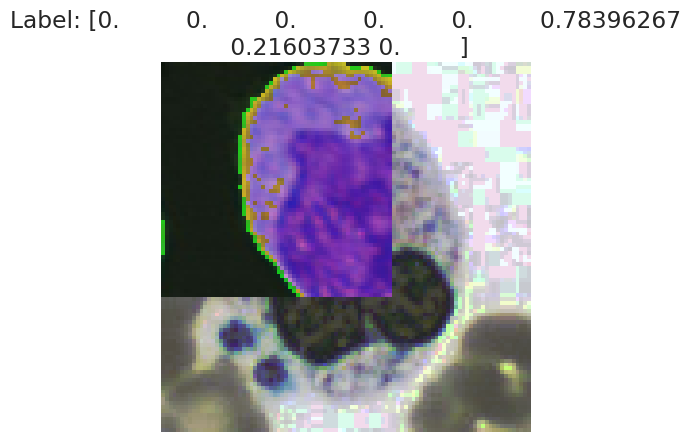

In [ ]:
import matplotlib.pyplot as plt

# Get a single batch from the dataset
for image, label in dataset.take(1):  # Take one batch (or one element if unbatched)
    # If the dataset is batched, take the first image in the batch
    if len(image.shape) == 4:  # Batch shape: (batch_size, height, width, channels)
        image = image[0]  # Take the first image in the batch
        label = label[0]  # Take the corresponding label

    # Display the image
    plt.imshow(image.numpy().astype("uint8"))  # Convert to NumPy and cast to uint8
    plt.title(f"Label: {label.numpy()}")  # Convert the label to NumPy for display
    plt.axis('off')  # Turn off axis
    plt.show()
    break  # Exit after visualizing one image

Initialise MobileNetV3Small model with pretrained weights, for transfer learning

In [ ]:
# Initialise MobileNetV3Small model with pretrained weights, for transfer learning
mobilenet = kcv.models.EfficientNetV2Backbone.from_preset("efficientnetv2_b0_imagenet")
# Freeze all layers in MobileNetV3Small to use it solely as a feature extractor
mobilenet.trainable = False

# Define input layer with shape matching the input images
inputs = tfk.Input(shape=INPUT_SHAPE, name='input_layer')

# Define a sequential model for image augmentation with various transformations
augmentation = tf.keras.Sequential([
    tfkl.RandomFlip("horizontal_and_vertical"),
    tfkl.RandomTranslation(0.1,0.1),
    tfkl.RandomRotation(0.1),
    tfkl.RandomZoom(0.1),
], name='preprocessing')

# Pass augmented inputs through the MobileNetV3Small feature extractor
x = augmentation(inputs, training=True)
x = mobilenet(x)

# Add a global average pooling
x = tfkl.GlobalAveragePooling2D(name='gap')(x)
# Add a dropout layer for regularisation
x = tfkl.Dropout(0.3, name='dropout')(x)

# Add final Dense layer for classification with softmax activation
outputs = tfkl.Dense(y_train.shape[-1], activation='softmax', name='dense')(x)

# Define the complete model linking input and output
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model with categorical cross-entropy loss and Adam optimiser
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(1e-4), metrics=['accuracy'])

# Display a summary of the model architecture
tl_model.summary(expand_nested=True)

# Display model architecture with layer shapes and trainable parameters
#tfk.utils.plot_model(tl_model, expand_nested=True, show_trainable=True, show_shapes=True, dpi=70)

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_8 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_13           │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_3               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_3 (RandomZoom)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b0_backbone          │ (None, 3, 3, 1280)          │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_6 (InputLayer)      │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_3 (Rescaling)         │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_ (FusedMBConvBlock)     │ (None, None, None, 16)      │           4,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_ (FusedMBConvBlock)     │ (None, None, None, 32)      │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2b_ (FusedMBConvBlock)     │ (None, None, None, 32)      │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3a_ (FusedMBConvBlock)     │ (None, None, None, 48)      │          43,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3b_ (FusedMBConvBlock)     │ (None, None, None, 48)      │          93,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4a_ (MBConvBlock)          │ (None, None, None, 96)      │          36,108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4b_ (MBConvBlock)          │ (None, None, None, 96)      │          99,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4c_ (MBConvBlock)          │ (None, None, None, 96)      │          99,4

 Total params: 5,929,560 (22.62 MB)

 Trainable params: 10,248 (40.03 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

## 🛠️ Train and Save the Model

In [ ]:
# Add your implementation here
model = tl_model

# Train the model
history = model.fit(
    dataset,
    batch_size = 64,
    epochs = 1000,
    validation_data = (X_val, y_val),
    class_weight = class_weight_dict,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

Epoch 1/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.1819 - loss: 2.0731 - val_accuracy: 0.5945 - val_loss: 1.6923
Epoch 2/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.3455 - loss: 1.9041 - val_accuracy: 0.6681 - val_loss: 1.3989
Epoch 3/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 223s 1s/step - accuracy: 0.4017 - loss: 1.7989 - val_accuracy: 0.6865 - val_loss: 1.2179
Epoch 4/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.4214 - loss: 1.7522 - val_accuracy: 0.7048 - val_loss: 1.1024
Epoch 5/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 261s 1s/step - accuracy: 0.4430 - loss: 1.7032 - val_accuracy: 0.7216 - val_loss: 1.0379
Epoch 6/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.4550 - loss: 1.6725 - val_accuracy: 0.7266 - val_loss: 0.9948
Epoch 7/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 195s 1s/step - accuracy: 0.4564 - loss: 1.6676 - val_accuracy: 0.7483 - val_loss: 0.9605
Epoch 8/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 201s 1s/step - accuracy: 0.4651 - loss: 1

In [ ]:
model.save('weights.keras')
del model

In [21]:
# Re-load the model after transfer learning
ft_model = tfk.models.load_model('weights.keras')
#ft_model.save('weights_firstWithAugmenter_83_03.keras')
# Display a summary of the model architecture
ft_model.summary(expand_nested=True)


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_8 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_13           │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_3               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_3 (RandomZoom)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b0_backbone          │ (None, 3, 3, 1280)          │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_4 (InputLayer)      │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_4 (Rescaling)         │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_ (FusedMBConvBlock)     │ (None, None, None, 16)      │           4,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_ (FusedMBConvBlock)     │ (None, None, None, 32)      │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2b_ (FusedMBConvBlock)     │ (None, None, None, 32)      │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3a_ (FusedMBConvBlock)     │ (None, None, None, 48)      │          43,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3b_ (FusedMBConvBlock)     │ (None, None, None, 48)      │          93,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4a_ (MBConvBlock)          │ (None, None, None, 96)      │          36,108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4b_ (MBConvBlock)          │ (None, None, None, 96)      │          99,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4c_ (MBConvBlock)          │ (None, None, None, 96)      │          99,4

 Total params: 11,798,514 (45.01 MB)

 Trainable params: 5,868,952 (22.39 MB)

 Non-trainable params: 60,608 (236.75 KB)

 Optimizer params: 5,868,954 (22.39 MB)

In [22]:
# Set the MobileNetV3Small model layers as trainable
ft_model.get_layer('efficient_net_v2b0_backbone').trainable = True

# Set all MobileNetV3Small layers as non-trainable
for layer in ft_model.get_layer('efficient_net_v2b0_backbone').layers:
    layer.trainable = False

# Enable training only for Conv2D and DepthwiseConv2D layers
for i, layer in enumerate(ft_model.get_layer('efficient_net_v2b0_backbone').layers):
    if isinstance(layer, tf.keras.layers.Conv2D) or isinstance(layer, tf.keras.layers.DepthwiseConv2D):
        layer.trainable = True
        print(i, layer.name, type(layer).__name__, layer.trainable)

2 stem_conv Conv2D True
26 top_conv Conv2D True


In [23]:
# Set the number of layers to freeze
N = 2
# Set the first N layers as non-trainable
for i, layer in enumerate(ft_model.get_layer('efficient_net_v2b0_backbone').layers[:N]):
    layer.trainable = False

# Print layer indices, names, and trainability status
for i, layer in enumerate(ft_model.get_layer('efficient_net_v2b0_backbone').layers):
    print(i, layer.name, layer.trainable)

# Display a summary of the model architecture
ft_model.summary(expand_nested=True)

0 input_layer_4 False
1 rescaling_4 False
2 stem_conv True
3 stem_bn False
4 stem_activation False
5 block1a_ False
6 block2a_ False
7 block2b_ False
8 block3a_ False
9 block3b_ False
10 block4a_ False
11 block4b_ False
12 block4c_ False
13 block5a_ False
14 block5b_ False
15 block5c_ False
16 block5d_ False
17 block5e_ False
18 block6a_ False
19 block6b_ False
20 block6c_ False
21 block6d_ False
22 block6e_ False
23 block6f_ False
24 block6g_ False
25 block6h_ False
26 top_conv True
27 top_bn False
28 top_activation False


Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ preprocessing (Sequential)           │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_flip_8 (RandomFlip)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_translation_13           │ (None, 96, 96, 3)           │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_rotation_3               │ (None, 96, 96, 3)           │               0 │
│ (RandomRotation)                     │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ random_zoom_3 (RandomZoom)      │ (None, 96, 96, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficient_net_v2b0_backbone          │ (None, 3, 3, 1280)          │       5,919,312 │
│ (EfficientNetV2Backbone)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ input_layer_4 (InputLayer)      │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ rescaling_4 (Rescaling)         │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_conv (Conv2D)              │ (None, None, None, 32)      │             864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_bn (BatchNormalization)    │ (None, None, None, 32)      │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ stem_activation (Activation)    │ (None, None, None, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block1a_ (FusedMBConvBlock)     │ (None, None, None, 16)      │           4,672 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2a_ (FusedMBConvBlock)     │ (None, None, None, 32)      │          11,648 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block2b_ (FusedMBConvBlock)     │ (None, None, None, 32)      │          41,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3a_ (FusedMBConvBlock)     │ (None, None, None, 48)      │          43,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block3b_ (FusedMBConvBlock)     │ (None, None, None, 48)      │          93,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4a_ (MBConvBlock)          │ (None, None, None, 96)      │          36,108 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4b_ (MBConvBlock)          │ (None, None, None, 96)      │          99,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│    └ block4c_ (MBConvBlock)          │ (None, None, None, 96)      │          99,4

 Total params: 11,798,514 (45.01 MB)

 Trainable params: 256,872 (1003.41 KB)

 Non-trainable params: 5,672,688 (21.64 MB)

 Optimizer params: 5,868,954 (22.39 MB)

In [24]:
# Compile the model
ft_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Lion(1e-3), metrics=['accuracy'])

In [ ]:
# Fine-tune the model
ft_history = ft_model.fit(
    dataset,
    batch_size = 128,
    epochs = 1000,
    validation_data = (X_val, y_val),
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=3, restore_best_weights=True)]
).history

# Calculate and print the final validation accuracy
final_val_accuracy = round(max(ft_history['val_accuracy'])* 100, 2)
print(f'Final validation accuracy: {final_val_accuracy}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'blood_cells'+str(final_val_accuracy)+'.keras'
ft_model.save(model_filename)

# Delete the model to free up resources
del ft_model

Epoch 1/1000
159/159 ━━━━━━━━━━━━━━━━━━━━ 351s 2s/step - accuracy: 0.5826 - loss: 1.4036 - val_accuracy: 0.8888 - val_loss: 0.4074
Epoch 2/1000
118/159 ━━━━━━━━━━━━━━━━━━━━ 1:22 2s/step - accuracy: 0.5885 - loss: 1.3831

In [16]:
ft_model = tfk.models.load_model(model_filename)
ft_model.save('weights.keras')

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'lion', because it has 245 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


TEST ON THE HOLD OUT TEST SET

In [17]:
class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 419ms/step
Predictions Shape: (598,)
[2 6 6 7 1 6 7 3 1 7 0 5 5 1 3 3 6 4 3 3 6 4 2 3 2 4 7 7 5 3 3 3 3 0 7 2 6
 5 5 2 7 5 7 5 0 3 3 3 0 0 1 1 3 1 2 7 1 3 1 3 3 3 3 1 7 6 3 5 0 4 5 6 6 3
 0 1 6 3 6 4 1 4 7 6 6 1 3 3 7 6 6 3 3 6 5 4 1 3 1 6 4 3 3 3 1 0 0 7 6 0 3
 1 1 2 3 5 0 6 1 6 1 0 1 0 7 5 1 2 7 7 1 4 1 5 5 3 6 7 5 7 5 2 7 1 6 3 0 5
 5 5 6 6 1 1 1 4 3 6 3 6 1 2 5 6 4 5 7 0 2 1 0 7 7 4 6 7 7 1 3 3 1 3 3 2 0
 0 3 4 4 2 3 2 2 1 6 7 2 1 1 6 6 7 7 1 4 7 4 0 3 6 3 2 3 0 7 1 3 6 7 7 3 4
 1 7 6 1 3 3 6 1 1 6 6 7 1 6 2 4 2 6 2 1 6 3 1 0 2 7 2 0 6 2 3 3 0 6 2 4 3
 7 0 3 2 4 3 7 3 3 4 6 7 2 6 4 1 2 3 6 6 3 6 5 3 1 7 6 3 1 6 1 6 6 1 6 2 6
 4 6 1 7 2 5 0 1 1 5 3 7 4 6 5 3 7 5 1 5 7 7 0 6 0 1 4 6 6 6 6 3 0 6 2 6 2
 7 5 5 3 3 3 4 7 1 3 3 2 7 1 3 4 6 5 3 3 6 6 1 2 0 6 1 1 6 5 4 3 7 1 1 1 0
 7 1 3 5 1 6 3 1 1 7 2 2 6 3 3 1 1 6 6 1 5 1 5 6 6 2 1 4 2 2 0 4 1 6 3 6 2
 6 1 3 2 5 2 7 7 7 1 0 7 6 5 5 3 1 3 0 0 0 6 1 1 7 7 7 7 3 5 1 4 7 7 5 6 6
 6 6 3 6 1 2 6 1 6 1 6 2 1 6 4 6

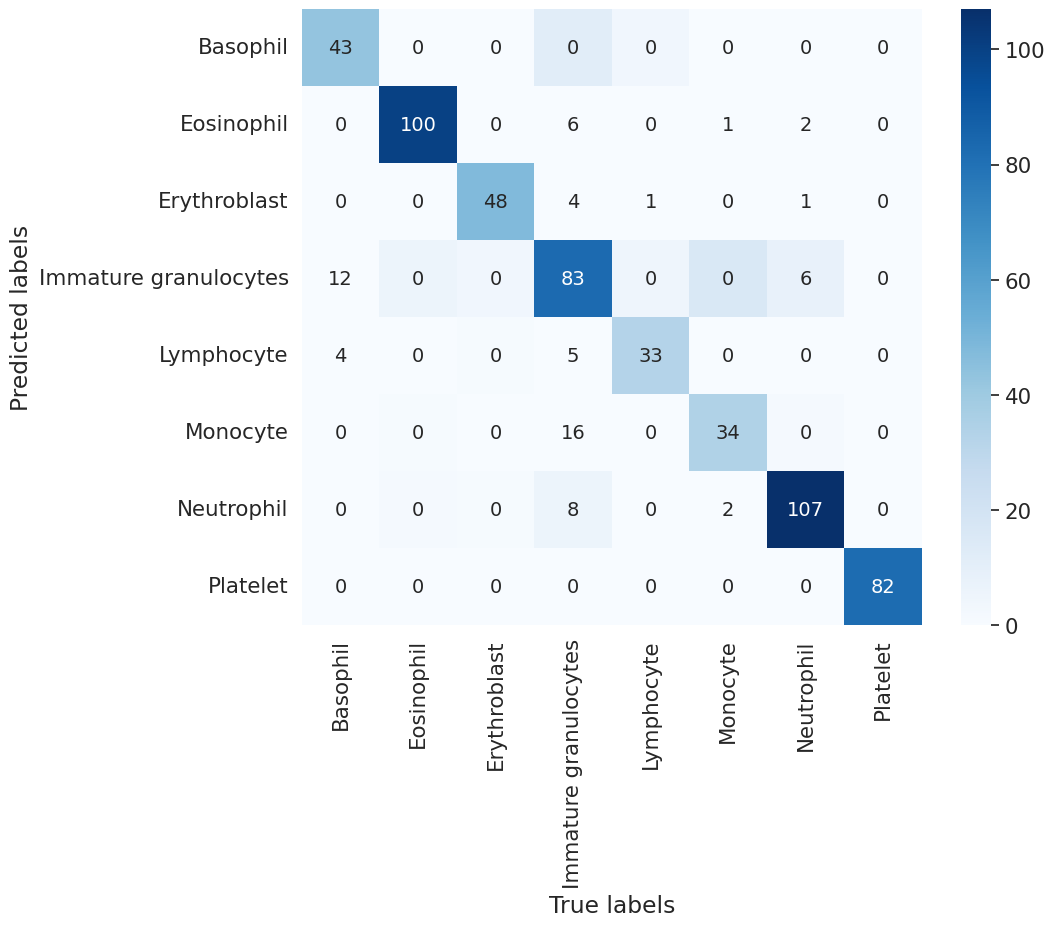

In [18]:
# Predict labels for the entire test set
model = Model()

predictions = model.predict(X_test)

# Display the shape of the predictions
print("Predictions Shape:", predictions.shape)

from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# Extract ground truth classes
true_classes = np.argmax(y_test, axis=-1)
print(true_classes)
# Calculate and display test set accuracy
accuracy = accuracy_score(true_classes, predictions)
print(f'Accuracy score over the test set: {round(accuracy, 4)}')

# Calculate and display test set precision
precision = precision_score(true_classes, predictions, average='weighted')
print(f'Precision score over the test set: {round(precision, 4)}')

# Calculate and display test set recall
recall = recall_score(true_classes, predictions, average='weighted')
print(f'Recall score over the test set: {round(recall, 4)}')

# Calculate and display test set F1 score
f1 = f1_score(true_classes, predictions, average='weighted')
print(f'F1 score over the test set: {round(f1, 4)}')

# Compute the confusion matrix
cm = confusion_matrix(true_classes, predictions)

# Combine numbers and percentages into a single string for annotation
annot = np.array([f"{num}" for num in cm.flatten()]).reshape(cm.shape)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm.T, annot=annot, fmt='', xticklabels=list(class_names), yticklabels=list(class_names), cmap='Blues')
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## 📊 Prepare Your Submission

To prepare your submission, create a `.zip` file that includes all the necessary code to run your model. It **must** include a `model.py` file with the following class:

```python
# file: model.py
class Model:
    def __init__(self):
        """Initialize the internal state of the model."""

    def predict(self, X):
        """Return a numpy array with the labels corresponding to the input X."""
```

The next cell shows an example implementation of the `model.py` file, which includes loading model weights from the `weights.keras` file and conducting predictions on provided input data. The `.zip` file is created and downloaded in the last notebook cell.

❗ Feel free to modify the method implementations to better fit your specific requirements, but please ensure that the class name and method interfaces remain unchanged.

In [19]:
%%writefile model.py
import numpy as np

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl


class Model:
    def __init__(self):
        """
        Initialize the internal state of the model. Note that the __init__
        method cannot accept any arguments.

        The following is an example loading the weights of a pre-trained
        model.
        """
        self.neural_network = tfk.models.load_model('weights.keras')

    def predict(self, X):
        """
        Predict the labels corresponding to the input X. Note that X is a numpy
        array of shape (n_samples, 96, 96, 3) and the output should be a numpy
        array of shape (n_samples,). Therefore, outputs must no be one-hot
        encoded.

        The following is an example of a prediction from the pre-trained model
        loaded in the __init__ method.
        """
        preds = self.neural_network.predict(X)
        if len(preds.shape) == 2:
            preds = np.argmax(preds, axis=1)
        return preds

Overwriting model.py


In [20]:
from datetime import datetime
filename = f'submission_{datetime.now().strftime("%y%m%d_%H%M%S")}.zip'

# Add files to the zip command if needed
!zip {filename} model.py weights.keras

from google.colab import files
files.download(filename)

  adding: model.py (deflated 56%)
  adding: weights.keras (deflated 54%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>